# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [4]:
# Your code here
# split data into target y and features X
y = df['Cover_Type'].copy()
X = df.drop(['Cover_Type'], axis = 1).copy() # I don't think copy is necessary here

# import package for train test split
from sklearn.model_selection import train_test_split

# perform train-test split; stratify along y because cottonwood/willow is rare
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [5]:
# Your code here
# import standard scaler to normalize features; kNN is distance based
from sklearn.preprocessing import StandardScaler

# instantiate and fit standard scaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

# transform test data with scaler fit to training data
X_test_scaled = ss.transform(X_test)

The following code checks that everything is set up correctly:

In [6]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [10]:
# Replace None with appropriate code

# Relevant imports
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Creating the model
knn_baseline_model = KNeighborsClassifier()

# Perform cross-validation
knn_baseline_log_loss = -1*cross_val_score(knn_baseline_model, X_train_scaled, y_train,
                                       scoring = 'neg_log_loss').mean()

knn_baseline_log_loss

0.1255288892455634

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [11]:
# Replace None with appropriate text
"""
This model is better than our logistic regression model in that it has a lower log loss, so
less "error" in its predictions. It is pretty slow to fit and evaluate this model. I don't
remember how long the logistic regression model took, but I think that it was faster (which
makes sense because kNN has to do a lot of work everytime it makes a prediction.) But it is
bearably slow.
"""

'\nThis model is better than our logistic regression model in that it has a lower log loss, so\nless "error" in its predictions. It is pretty slow to fit and evaluate this model. I don\'t\nremember how long the logistic regression model took, but I think that it was faster (which\nmakes sense because kNN has to do a lot of work everytime it makes a prediction.) But it is\nbearably slow.\n'

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

### Adjust Number of Neighbors

In [63]:
# Your code here (add more cells as needed)
''' Let's try changing the number of neighbors. We will do a loop from 1 to 20 (odds only.)'''

# make a list of k-values to try
k_values = list(range(1, 20, 2))
# make corresponding labels in case needed
k_value_labels = [f'k = {k}' for k in k_values]
# make a list to hold log loss for each iteration of the model
log_losses = []

for k in k_values:
    # fit knn model with k neighbors to training data
    knn_more_or_less_neighbors = KNeighborsClassifier(n_neighbors = k)
    
    # calculate mean log loss over all train-test splits performed by cross_val_score
    knn_more_or_less_neighbors_log_loss = -1*cross_val_score(knn_more_or_less_neighbors,
                                                             X_train_scaled,
                                                             y_train,
                                                             scoring = 'neg_log_loss').mean()
    # append resulting mean log loss to log_losses list
    log_losses.append(knn_more_or_less_neighbors_log_loss)
    
log_losses

[0.49521049185151506,
 0.17451432403739855,
 0.1255288892455634,
 0.0895925912090358,
 0.07966757716809988,
 0.07273052026135858,
 0.06972901169429604,
 0.06722997851589525,
 0.06376302967813,
 0.0633161801415997]

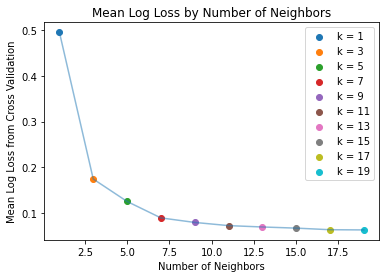

In [20]:
# Visualize results of above model iteration
# I needed to make this cell separate so that I didn't have to recompute mean log losses =)

# import packages for visualization
import matplotlib.pyplot as plt

# set up a figure and axes for graph
fig, ax = plt.subplots()

# for each k-value, plot a point (k-value, log loss), and put label 'k = k' in legend
for index, k in enumerate(k_values):
    plt.scatter(k, log_losses[index], marker = 'o', label = k_value_labels[index])

# then plot a curve through all of the points; make it slightly transparent
plt.plot(k_values, log_losses, alpha = 0.5)

# show legend
ax.legend()

# add x- and y- axis labels, and a title, to the graph
ax.set(title = 'Mean Log Loss by Number of Neighbors', xlabel = 'Number of Neighbors',
      ylabel = 'Mean Log Loss from Cross Validation');

This is an interesting result! The log loss keeps decreasing as I increase the number of neigbors. Let's see the mean log loss for each k-value.

In [21]:
log_losses

[0.49521049185151506,
 0.17451432403739855,
 0.1255288892455634,
 0.0895925912090358,
 0.07966757716809988,
 0.07273052026135858,
 0.06972901169429604,
 0.06722997851589525,
 0.06376302967813,
 0.0633161801415997]

In [22]:
# the percent change from k = 17 log loss to k = 19 log loss is:
improvement = (log_losses[-1] - log_losses[-2]) / log_losses[-2]
print(f'The percent decrease in mean log loss from 17 to 19 neighbors is: {improvement}')

The percent decrease in mean log loss from 17 to 19 neighbors is: -0.007007972155431566


Because the percent decrease in log loss is so small (less than 1%) and it takes so long to make predictions with a kNN model, I think I might leave the number of neighbors at 19 for now.

### Change Distance Metric

In [23]:
'''For the next iteration, let's try changing the distance metric to Manhattan distance.'''

# instantiate model with p = 1, but all other parameters at default; we will experiment with
# number of neighbors again next
knn_manhattan_dist = KNeighborsClassifier(p = 1)

# fit to training data
knn_manhattan_dist.fit(X_train_scaled, y_train)

# cross-validate!
knn_manhattan_dist_log_loss = -1*cross_val_score(knn_manhattan_dist,
                                                 X_train_scaled,
                                                 y_train,
                                                scoring = 'neg_log_loss').mean()

print(knn_manhattan_dist_log_loss)

0.1144531688354272


The log-loss is a little bit better with Manhattan distance than with the default Euclidean distance. Let's now try Manhattan distance with different numbers of neighbors and see what results we det.

### Revisit Number of Neighbors with New Distance Metric

In [24]:
# Repeat code from above to try out different numbers of neighbors, but change p to 1

# list of k-values to try
k_values = list(range(1, 20, 2))
# corresponding labels for plotting
k_value_labels = [f'k = {k}' for k in k_values]
# make a list to hold log loss for each iteration of the model
log_losses = []

for k in k_values:
    # fit knn model with k neighbors to training data; set p = 1 for Manhattan distance
    knn_more_or_less_neighbors_p1 = KNeighborsClassifier(n_neighbors = k, p = 1)
    
    # calculate mean log loss over all train-test splits performed by cross_val_score
    knn_more_or_less_neighbors_p1_log_loss = -1*cross_val_score(knn_more_or_less_neighbors_p1,
                                                             X_train_scaled,
                                                             y_train,
                                                             scoring = 'neg_log_loss').mean()
    # append resulting mean log loss to log_losses list
    log_losses.append(knn_more_or_less_neighbors_p1_log_loss)
    
log_losses

[0.5119568975553388,
 0.16370780348980501,
 0.1144531688354272,
 0.08441299087246057,
 0.06374575533465694,
 0.06172556244896841,
 0.0630702704169221,
 0.061714464254211454,
 0.060419917049137906,
 0.061214951514946325]

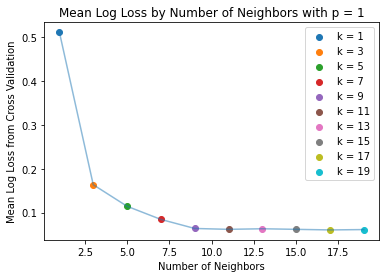

In [25]:
# Visualize results of above model iteration

# set up a figure and axes for graph
fig, ax = plt.subplots()

# for each k-value, plot a point (k-value, log loss), and put label 'k = k' in legend
for index, k in enumerate(k_values):
    plt.scatter(k, log_losses[index], marker = 'o', label = k_value_labels[index])

# then plot a curve through all of the points; make it slightly transparent
plt.plot(k_values, log_losses, alpha = 0.5)

# show legend
ax.legend()

# add x- and y- axis labels, and a title, to the graph
ax.set(title = 'Mean Log Loss by Number of Neighbors with p = 1',
       xlabel = 'Number of Neighbors',
      ylabel = 'Mean Log Loss from Cross Validation');

Well, the difference between p = 1 and p = 2 with 19 neighbors is minimal, but the Manhattan distance model came out slightly on top.

If I have time, I want to iterate over a few more values for k (the number of neighbors) to see if there is an even higher number of neighbors that works better, or if k = 19 results in the minimal log loss. For now, I will say that the Manhattan distance model with k = 19 is the best.

In [61]:
# iterate over values of k from 17 to 30 (odds only) to see if there is an even better k...

# list of k-values to try
k_values2 = list(range(17, 30, 2))
# corresponding labels for plotting
k_value_labels = [f'k = {k}' for k in k_values]
# make a list to hold log loss for each iteration of the model
log_losses = []

for k in k_values2:
    # fit knn model with k neighbors to training data; set p = 1 for Manhattan distance
    knn_neighbors_p1 = KNeighborsClassifier(n_neighbors = k, p = 1)
    
    # calculate mean log loss over all train-test splits performed by cross_val_score
    knn_neighbors_p1_log_loss = -1*cross_val_score(knn_neighbors_p1,
                                                             X_train_scaled,
                                                             y_train,
                                                             scoring = 'neg_log_loss').mean()
    # append resulting mean log loss to log_losses list
    log_losses.append(knn_neighbors_p1_log_loss)
    
log_losses

[0.060419917049137906,
 0.061214951514946325,
 0.061980892331987184,
 0.063630723250797,
 0.06519186918054885,
 0.06659189026114101,
 0.06699365809376268]

In [62]:
# which number of neighbors minimizes log loss the most?

k_values2[np.argmin(log_losses)]

17

In [64]:
# import package to "clone" unfitted estimator with the same parameters
from sklearn.base import clone # used later instead

# select best kNN model
best_knn_model = KNeighborsClassifier(n_neighbors = 17, p = 1)

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [28]:
# Your code here
# import necessary packages
from sklearn.tree import DecisionTreeClassifier

# instantiate decision tree
baseline_dt = DecisionTreeClassifier(random_state = 42)

# cross validate on training data (X_train does not need to be scaled)
baseline_score = -1*cross_val_score(baseline_dt,
                                    X_train,
                                    y_train,
                                    scoring = 'neg_log_loss').mean()

baseline_score

0.7045390124149022

Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [ ]:
# Replace None with appropriate text
"""
This log loss is absolutely terrible compared to our best logistic regression and kNN models.
I can't fathom why this would be the case. Could it be underfitting? Overfitting?
"""

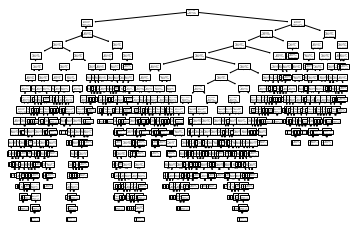

In [31]:
# Before we move on, I want to understand better why this tree is so bad
# Let's import the package needed to plot the tree
from sklearn.tree import plot_tree

# I have to fit the tree to the training data in order to plot it; it won't be exactly the
# same as the trees fit to the folds, but I think it will quickly give me an idea of what to
# adjust
baseline_dt.fit(X_train, y_train)

# plot tree
plot_tree(baseline_dt);

As suspected, the tree is pretty dense! It is hard to see how many samples are remaining in each leaf, but I would guess that leaves with *more* samples would be more desirable. Let's try tuning the parameter `min_samples_leaf` to see if we can prune this tree to a more reasonable log-loss.

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

### Adjust Leaf Size

In [34]:
# Your code here (add more cells as needed)
'''Let's first consider the case that our tree may be overfitting on the training folds. To
remedy this, we will prune the tree by adjusting the parameter: min_samples_leaf'''

# our training set contains 28,875 records; let's try setting to ~0.1%, 0.5%, 1%, 5%, 10%
min_leaf_size = [30, 150, 300, 600, 1000, 3000] # threw 1000 in there for fun
log_losses = []

for size in min_leaf_size:
    # instantiate a tree with the given min_leaf_size, size
    dt_pruned = DecisionTreeClassifier(random_state = 42,
                                      min_samples_leaf = size)
    
    # get the mean log loss for 5 fold cross validation
    log_loss_pruned = -1*cross_val_score(dt_pruned,
                                         X_train,
                                         y_train,
                                         scoring = 'neg_log_loss').mean()
    
    # store results
    log_losses.append(log_loss_pruned)

log_losses

[0.16076367830299224,
 0.11278679228111226,
 0.1210069857263327,
 0.142869032483025,
 0.1565794051720158,
 0.1916131426039682]

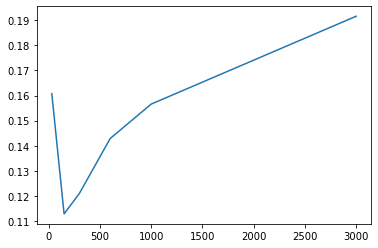

In [35]:
# let's quickly visualize the above

fig, ax = plt.subplots()

plt.plot(min_leaf_size, log_losses);

In [37]:
# find minimum leaf size which minimized log loss
import numpy as np

min_leaf_size[np.argmin(log_losses)]

150

It's probably worth repeating the above with a range of values between 30 and 300, maybe every 10, to find the *best* min leaf size.

Min_samples_leaf which minimizes log loss: 180


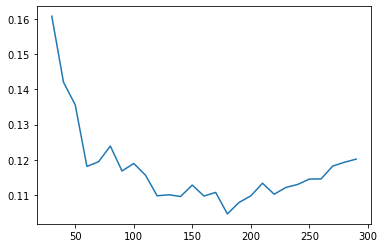

In [56]:
# find best min leaf size

min_leaf_size = list(range(30, 300, 10)) # 30 to 290 by 10s
log_losses = []

for size in min_leaf_size:
    # instantiate a tree with the given min_leaf_size, size
    dt_pruned = DecisionTreeClassifier(random_state = 42,
                                      min_samples_leaf = size)
    
    # get the mean log loss for 5 fold cross validation
    log_loss_pruned = -1*cross_val_score(dt_pruned,
                                         X_train,
                                         y_train,
                                         scoring = 'neg_log_loss').mean()
    
    # store results
    log_losses.append(log_loss_pruned)

print(f'Min_samples_leaf which minimizes log loss: {min_leaf_size[np.argmin(log_losses)]}')

# quickly visualize results

fig, ax = plt.subplots()

plt.plot(min_leaf_size, log_losses);

### Adjust Max Depth (instead of Leaf Size)

Max depth which minimizes log loss: 5


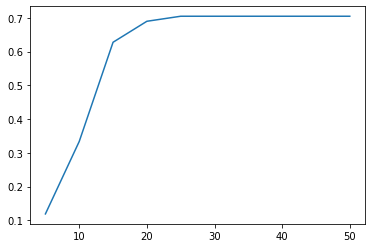

In [46]:
# Your code here (add more cells as needed)
'''Now let's check out an alternative approach to pruning. Rather than adjusting the min leaf
size, let's set a max depth based on how many splits we are willing to make. Exluding soil
type, there are only 14 to 15 unique features in our dataset.'''

# let's limit the depth to 5, 10, 15, 20, 25, ... up to 50 to reflect inclusion of more &
# more features, so to speak (this doesn't work exactly, because you can split on the same
# feature more than once with a decision tree, but it's something)
depths = list(range(5, 55, 5))

labels = [f'max_depth = {depth}' for depth in depths]

log_losses = []

for depth in depths:
    # instantiate a tree with the given max_depth, depth; leave other parameters default
    dt_max_depth = DecisionTreeClassifier(random_state = 42,
                                      max_depth = depth)
    
    # get the mean log loss for 5 fold cross validation
    log_loss_max_depth = -1*cross_val_score(dt_max_depth,
                                         X_train,
                                         y_train,
                                         scoring = 'neg_log_loss').mean()
    
    # store results
    log_losses.append(log_loss_max_depth)
    
print(f'Max depth which minimizes log loss: {depths[np.argmin(log_losses)]}')

# quickly visualize results

fig, ax = plt.subplots()

plt.plot(depths, log_losses);

So a maximum depth of 5 minimizes the log loss, out of the range I specified. Let's repeat the above with max depths from 1 to 5.

Max depth which minimizes log loss: 5


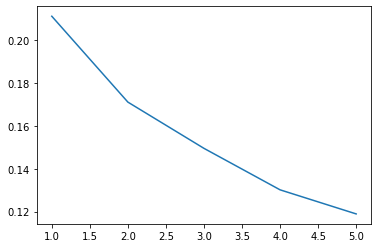

In [47]:
# is 5 the max depth which minimizes log loss, or should we make even fewer splits? (Which, to
# me, would start to call the model into question due to lack of complexity...)
depths = [1, 2, 3, 4, 5]

labels = [f'max_depth = {depth}' for depth in depths]

log_losses = []

for depth in depths:
    # instantiate a tree with the given max_depth, depth; leave other parameters default
    dt_max_depth = DecisionTreeClassifier(random_state = 42,
                                      max_depth = depth)
    
    # get the mean log loss for 5 fold cross validation
    log_loss_max_depth = -1*cross_val_score(dt_max_depth,
                                         X_train,
                                         y_train,
                                         scoring = 'neg_log_loss').mean()
    
    # store results
    log_losses.append(log_loss_max_depth)
    
print(f'Max depth which minimizes log loss: {depths[np.argmin(log_losses)]}')

# quickly visualize results

fig, ax = plt.subplots()

plt.plot(depths, log_losses);

`max_depth` of 5 is the best. But `min_samples_leaf` of 180 is even better.

### Adjust Impurity Decrease (in place of Other Pruning Methods)

Min impurity decrease which minimizes log loss: 0.05


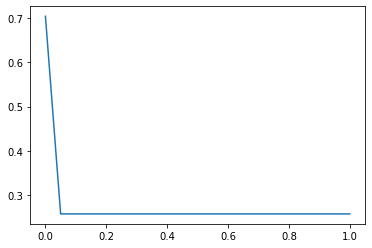

In [50]:
# Your code here (add more cells as needed)
'''Lastly, let's experiment with telling the tree to only split if it will produce an
impurity decrease of some specific value or more. We may need to repeat this several times to
find an adequate range for the parameter value.'''

impurity_decreases = np.linspace(0, 1, 21) # 0 should be default

log_losses = []

for decrease in impurity_decreases:
    # instantiate a tree with the given min_impurity_decrease; leave other parameters default
    dt_impurity = DecisionTreeClassifier(random_state = 42,
                                      min_impurity_decrease = decrease)
    
    # get the mean log loss for 5 fold cross validation
    log_loss_impurity = -1*cross_val_score(dt_impurity,
                                         X_train,
                                         y_train,
                                         scoring = 'neg_log_loss').mean()
    
    # store results
    log_losses.append(log_loss_impurity)
    
print(f'Min impurity decrease which minimizes log loss: {impurity_decreases[np.argmin(log_losses)]}')

# quickly visualize results

fig, ax = plt.subplots()

plt.plot(impurity_decreases, log_losses);

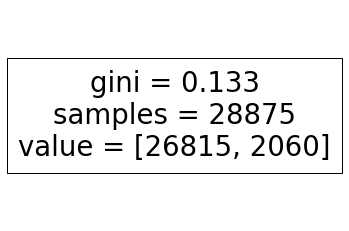

In [53]:
# quickly check: does the best tree above actually do anything other than guessing once?

# clone best model
best_decision_tree = clone(dt_impurity)

# fit to training data
best_decision_tree.fit(X_train, y_train)

# plot
plot_tree(best_decision_tree);

Yep. The "best" decision tree doesn't make any decisions at all! It just guesses the majority.

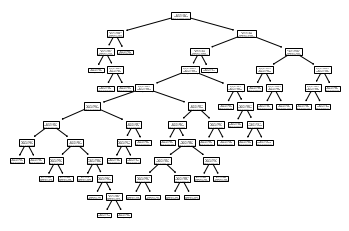

In [55]:
# use min_samples_leaf for best model instead

best_decision_tree = DecisionTreeClassifier(random_state = 42,
                                      min_samples_leaf = size)

# fit to training data & plot, just to check

best_decision_tree.fit(X_train, y_train)

plot_tree(best_decision_tree);

A little more complex - looks better!

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [57]:
# was knn or decision tree best model the best?

knn_score = -1*cross_val_score(best_knn_model,
                               X_train_scaled,
                               y_train,
                               scoring = 'neg_log_loss').mean()

dt_score = -1*cross_val_score(best_decision_tree,
                               X_train,
                               y_train,
                               scoring = 'neg_log_loss').mean()

print(f'kNN best log loss: {knn_score}')
print(f'Decision tree best log loss: {dt_score}')

kNN best log loss: 0.061214951514946325
Decision tree best log loss: 0.12016541764448559


kNN is better by a long shot!

In [58]:
# Replace None with appropriate code
final_model = clone(best_knn_model)

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=19, p=1)

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [60]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.06448869420648831
accuracy:  0.9779763141491793
precision: 0.9018612521150592
recall:    0.7758369723435226


Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [ ]:
# Replace None with appropriate text
"""
See below
"""

The log loss of the final model on the testing set is 0.0644, similar to the mean log loss of 0.0612 of the model on the cross validation folds of the training set. This seems promising that it is not an overfit model. The accuracy of the model is 97.798%, an improvement over the ~92% accuracy of a dummy model that always chooses the majority class *and* and improvement over the accuracy of our previous logistic regression model, 94.567%. The precision of the model is 90.186%; about 90% of predictions made by the model of the more rare species of tree are correct. The recall, on the other hand, is only 77.584%; the model is missing a little more than 20% of the cottonwood / willow trees in the dataset. This is not promising if the whole purpose of the model is to locate areas with the more rare species of tree. We would want to improve recall of the cottonwood / willow trees somehow, even at the expense of precision.

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.